In [1]:
import re
import pandas as pd
import numpy as np

In [2]:
# # Saves dictionary in same format
# np.save('my_file.npy', all_desc) 

# # # Loads dictionary in same format so we don't have to webscrape all the time
read_dictionary = np.load('my_file.npy').item()

In [3]:
edu  = read_dictionary

In [4]:
edu.keys()

dict_keys(['EDUCATION', 'BUSINESS', 'DATING', 'SPORTS', 'WEATHER', 'FOOD_AND_DRINK', 'HEALTH_AND_FITNESS', 'BEAUTY', 'MUSIC_AND_AUDIO', 'NEWS_AND_MAGAZINES', 'SOCIAL', 'SHOPPING', 'PRODUCTIVITY', 'PHOTOGRAPHY', 'MEDICAL', 'PARENTING', 'COMMUNICATION', 'TOOLS'])

# NLTK Clean up

In [5]:
import nltk
import sklearn

from nltk.collocations import *
from nltk import FreqDist, word_tokenize
import string, re
from nltk.stem.snowball import SnowballStemmer

In [6]:
# patter to capture using regex
pattern = "([a-zA-Z]+(?:'[a-z]+)?)"

In [7]:
# stop words
from nltk.corpus import stopwords
stopwords.words("english")

stop_words = set(stopwords.words('english'))

In [8]:
# stem words
stemmer = SnowballStemmer("english")

In [9]:
def text_cleaner(description):
    ''''''
    tokens_raw = nltk.regexp_tokenize(description, pattern)
    tokens = [i.lower() for i in tokens_raw]
    tokens_stopped = [w for w in tokens if not w in stop_words]
    stemmed = [stemmer.stem(word) for word in tokens_stopped]
    cleaned = ' '.join(stemmed)
    return cleaned

In [10]:
def dict_cleaner(dictionary):
    description_list = []
    for c, d in dictionary.items():
        for description in d:
            cleaned = text_cleaner(description)
            description_list.append(cleaned)
    return description_list

In [11]:
# description list is a list of all descriptions stemmed and in order
description_list = dict_cleaner(edu)

In [12]:
new_df = pd.DataFrame(description_list, columns=['desc'])

In [13]:
# Because we had exactly 60 items in each category this creates a list
# with 60 items of each key.
def create_labels(dictionary):
    x = dictionary.keys()
    new_list = []
    for c in x: 
        s = [c] * len(dictionary[c])
        new_list += s
    return new_list

In [14]:
labels = create_labels(edu)

In [15]:
new_df['labels'] = labels

In [16]:
new_df.head()

,desc,labels
0,es una app genial porqu aprend palabra nueva p...,EDUCATION
1,unlock math calcul math solut take photo math ...,EDUCATION
2,learn anyth free forev spend afternoon brush s...,EDUCATION
3,updat info latest updat new section ad learn l...,EDUCATION
4,join million learner learn code make app game ...,EDUCATION


## Frequency Distributions

In [17]:
i = 0
listy = []
for key in edu.keys():
    string = ''
    for x in range(i, i + 60):
        string += description_list[i]
    listy.append(string)
    i += 60

In [18]:
def get_most_common(keys, lis_t, n_words=50):
    key_words = []
    for key, string in zip(keys, lis_t):
        meta_freqdist = FreqDist(string.split())
        key_words.append((key, meta_freqdist.most_common(n_words)))
    return key_words

In [19]:
key_words = get_most_common(edu.keys(), listy)

In [20]:
# graphs words vs frequency
# meta_freqdist.plot(30,cumulative=False);

### Building wordclouds based on key_words

#### USING PLOTLY...MEH

In [41]:
import plotly
import plotly.graph_objs as go
from plotly.offline import plot
import random

In [42]:
import time

In [43]:
from sklearn.preprocessing import MinMaxScaler

In [44]:
def build_word_cloud(tuppple):
    words = [x[0] for x in tuppple[1]]
    colors = [plotly.colors.DEFAULT_PLOTLY_COLORS[random.randrange(1, 10)] for i in range(30)]

    weights_ = []
    for x in tuppple[1]:
        if x[1] >= 5:
            weights_.append(round(x[1]/5))
        else:
            weights_.append(x[1])
#     scaler = MinMaxScaler()
#     weights_ = scaler.fit_transform(np.array([x[1] for x in tuppple[1]]).reshape(-1,1))
#     y = weights_.flatten()*10
#     weights = y.round().astype(int)
    weights = weights_

    data = go.Scatter(x=[random.random() for i in range(30)],
                     y=[random.random() for i in range(30)],
                     mode='text',
                     text=words,
                     marker={'opacity': 0.3},
                     textfont={'size': weights,
                               'color': colors})
    layout = go.Layout({ 'title' : f'{tuppple[0]}',
                        'xaxis': {'showgrid': False, 'showticklabels': False, 'zeroline': False},
                        'yaxis': {'showgrid': False, 'showticklabels': False, 'zeroline': False}})
    fig = go.Figure(data=[data], layout=layout)

    plot(fig)


In [45]:
# Loops through topics and displays word clouds for each topic every 3 seconds
for topic in key_words:
    build_word_cloud(topic)
    time.sleep(5)

#### USING WORDCLOUD

In [21]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [23]:
import matplotlib.pyplot as plt

In [26]:
len(listy[0])

301320

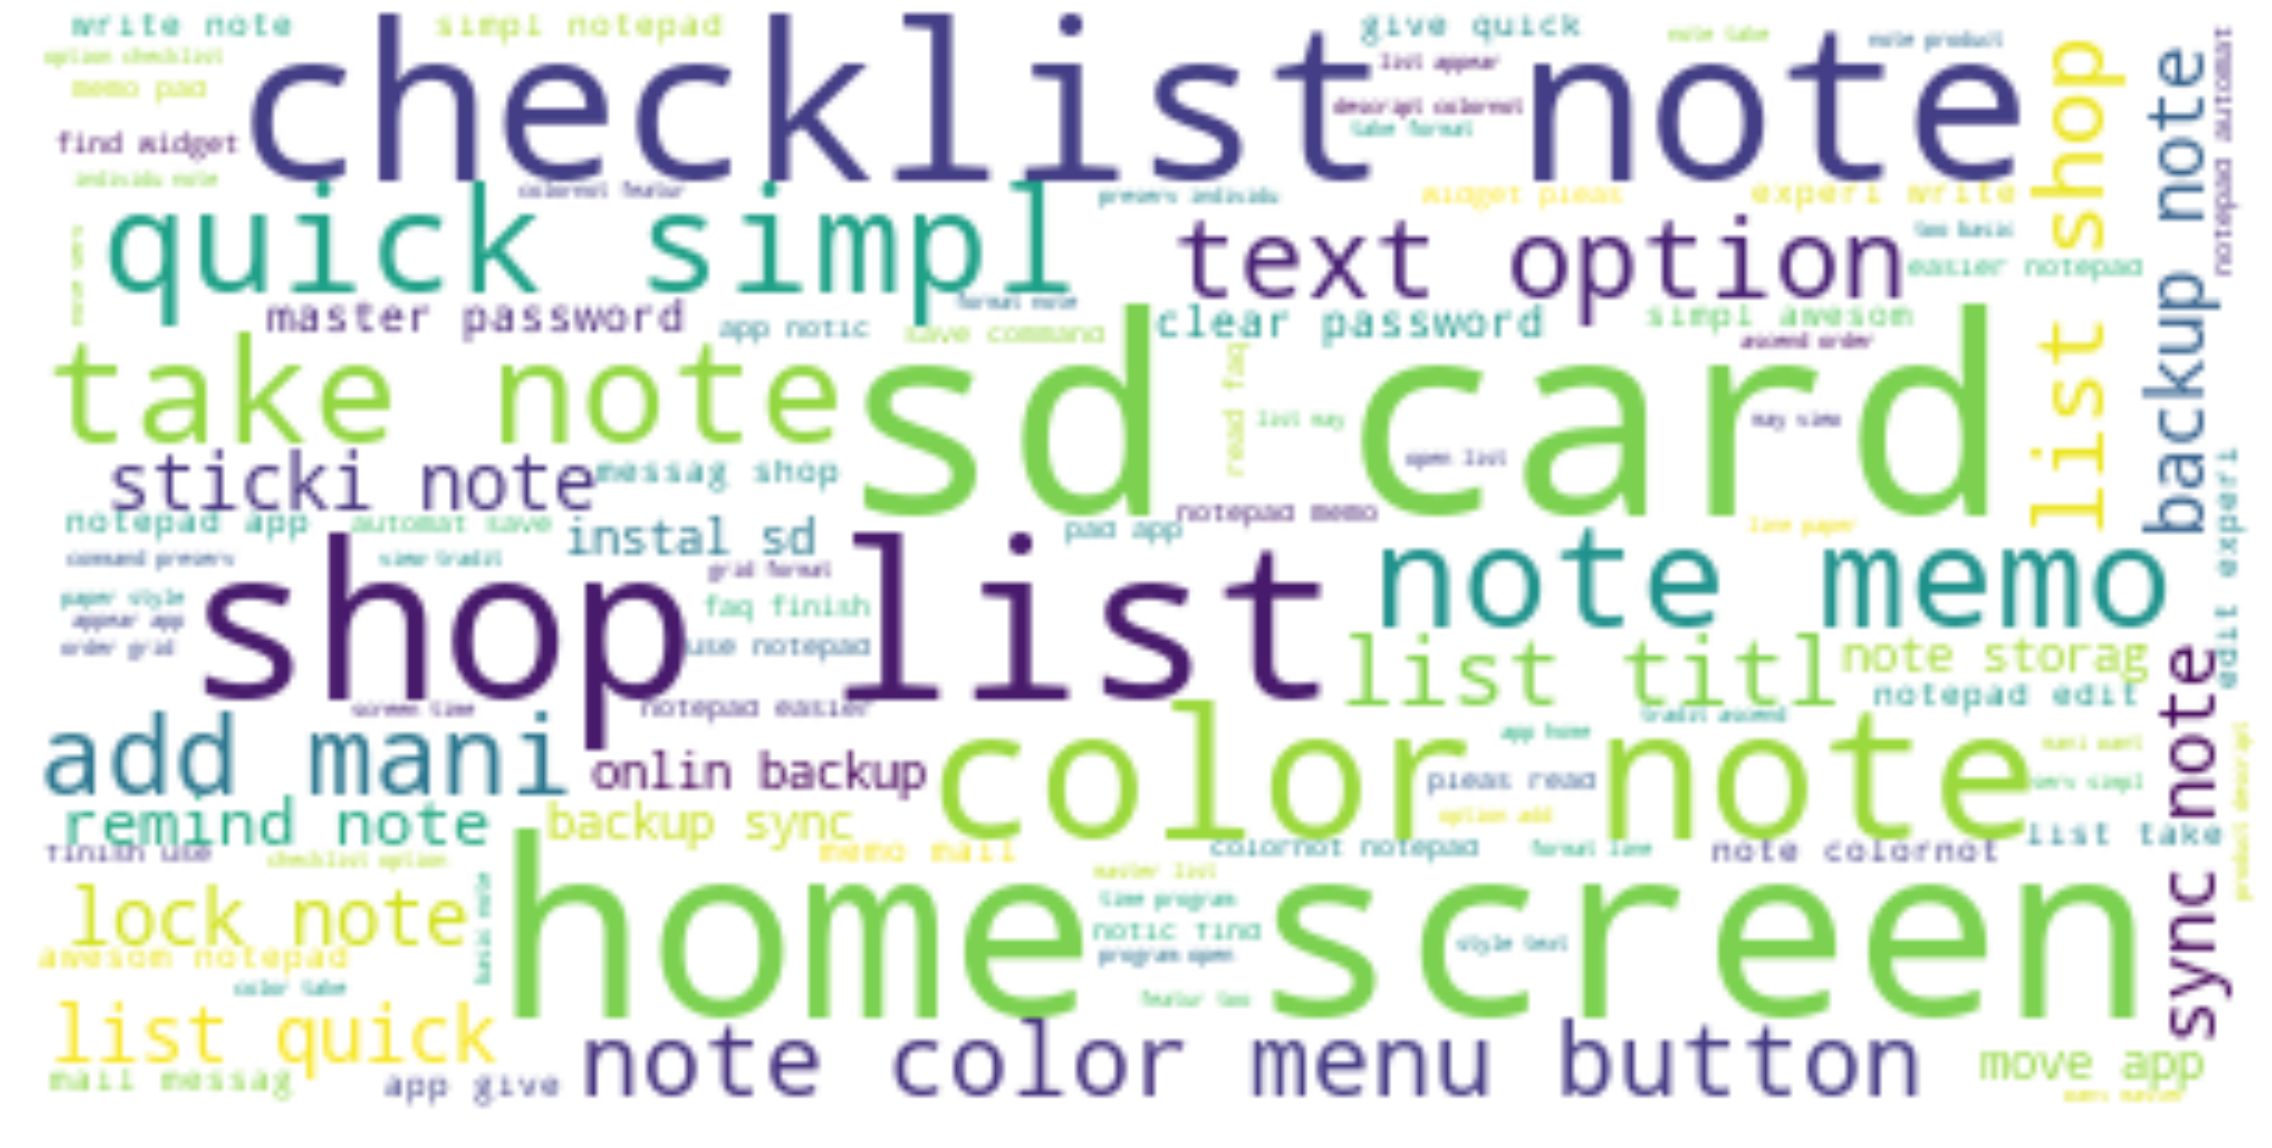

In [46]:
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(listy[12])

# Display the generated image:
plt.figure(figsize=[40,40])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Test-Train Split

In [47]:
new_df.columns

Index(['desc', 'labels'], dtype='object')

In [49]:
y = new_df.labels

In [50]:
X = new_df.desc

In [51]:
# Sample code
from sklearn.model_selection import train_test_split  
X_tr, X_te, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)  

## tf-idf

In [52]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()

In [53]:
response = tfidf.fit_transform(X_tr)

In [54]:
X_train = response

In [56]:
X_train = pd.DataFrame(response.toarray(), columns=tfidf.get_feature_names())

In [59]:
X_test = tfidf.transform(X_te)
X_test = pd.DataFrame(X_test.toarray(), columns=tfidf.get_feature_names())

In [60]:
non_zero_cols = response.nnz / float(response.shape[0])
print("Average Number of Non-Zero Elements in Vectorized Reviews: {}".format(non_zero_cols))

percent_sparse = 1 - (non_zero_cols / float(response.shape[1]))
print('Percentage of columns containing 0: {}'.format(percent_sparse))

Average Number of Non-Zero Elements in Vectorized Reviews: 112.73032407407408
Percentage of columns containing 0: 0.9903360202251115


In [31]:
# ROC CURVE FOR MODELS AND OTHERS SHOWING PREFORMANCE, <- CANT DO... 
# TEXT RELATED VIZUALISATIONS LIKE WORD CLOUD, LATENT SEMANTIC ANALYSIS
# FEATURE IMPORTANCE ON RF, NB
# CREATE VIZ OF ENSEMBLE MODELS
# TYING SPECIFIC 

# TPOT for automated model selection

In [69]:
from tpot import TPOTClassifier

In [70]:
classifier_config_dict = {

    # Classifiers
    
    'sklearn.naive_bayes.MultinomialNB': {
        'alpha': [1e-3, 1e-2, 1e-1, 1., 10., 100.],
        'fit_prior': [True, False]
    },

    'sklearn.tree.DecisionTreeClassifier': {
        'criterion': ["gini", "entropy"],
        'max_depth': range(1, 11),
        'min_samples_split': range(2, 21),
        'min_samples_leaf': range(1, 21)
    },

    'sklearn.ensemble.ExtraTreesClassifier': {
        'n_estimators': [100],
        'criterion': ["gini", "entropy"],
        'max_features': np.arange(0.05, 1.01, 0.05),
        'min_samples_split': range(2, 21),
        'min_samples_leaf': range(1, 21),
        'bootstrap': [True, False]
    },

    'sklearn.ensemble.RandomForestClassifier': {
        'n_estimators': [100],
        'criterion': ["gini", "entropy"],
        'max_features': np.arange(0.05, 1.01, 0.05),
        'min_samples_split': range(2, 21),
        'min_samples_leaf':  range(1, 21),
        'bootstrap': [True, False]
    },

    'sklearn.neighbors.KNeighborsClassifier': {
        'n_neighbors': range(1, 101),
        'weights': ["uniform", "distance"],
        'p': [1, 2]
    },

    'sklearn.svm.LinearSVC': {
        'penalty': ["l1", "l2"],
        'loss': ["hinge", "squared_hinge"],
        'dual': [True, False],
        'tol': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1],
        'C': [1e-4, 1e-3, 1e-2, 1e-1, 0.5, 1., 5., 10., 15., 20., 25.]
    },


    # Preprocesssors
   'sklearn.decomposition.PCA': {
        'n_components' : [.85, .9, .95, .975],
        'svd_solver': ['randomized'],
        'iterated_power': range(1, 11)
    },

    'sklearn.kernel_approximation.RBFSampler': {
        'gamma': np.arange(0.0, 1.01, 0.05)
    },


    'tpot.builtins.OneHotEncoder': {
        'minimum_fraction': [0.05, 0.1, 0.15, 0.2, 0.25],
        'sparse': [False],
        'threshold': [10]
    },

    # Selectors
    'sklearn.feature_selection.SelectFwe': {
        'alpha': np.arange(0, 0.05, 0.001),
        'score_func': {
            'sklearn.feature_selection.f_classif': None
        }
    },

    'sklearn.feature_selection.SelectPercentile': {
        'percentile': range(1, 100),
        'score_func': {
            'sklearn.feature_selection.f_classif': None
        }
    },

    'sklearn.feature_selection.VarianceThreshold': {
        'threshold': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.2]
    },

    'sklearn.feature_selection.RFE': {
        'step': np.arange(0.05, 1.01, 0.05),
        'estimator': {
            'sklearn.ensemble.ExtraTreesClassifier': {
                'n_estimators': [100],
                'criterion': ['gini', 'entropy'],
                'max_features': np.arange(0.05, 1.01, 0.05)
            }
        }
    },

    'sklearn.feature_selection.SelectFromModel': {
        'threshold': np.arange(0, 1.01, 0.05),
        'estimator': {
            'sklearn.ensemble.ExtraTreesClassifier': {
                'n_estimators': [100],
                'criterion': ['gini', 'entropy'],
                'max_features': np.arange(0.05, 1.01, 0.05)
            }
        }
    }

}


In [71]:
# Changed generation and population parameters to get better results
tpot = TPOTClassifier(generations=5, cv = 3 ,population_size=10,\
                      max_eval_time_mins=10,
                      config_dict=classifier_config_dict ,
                      verbosity=3)

In [ ]:
tpot.fit(X_train, y_train)

14 operators have been imported by TPOT.


In [91]:
tpot.export('interrupted3-pipeline.py')

True

In [72]:
exported_pipeline = LogisticRegression(C=5.0, dual=True, penalty="l2")
exported_pipeline.fit(X_train, y_train)
exported_pipeline.score(X_test, y_test)

/Users/vicenteecheveste/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/vicenteecheveste/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


0.8148148148148148

In [66]:
from sklearn.linear_model import LogisticRegression

In [ ]:
# 0.8009259259259259 First pipeline trial
# 0.8055555555555556 Second pipeline trial
# 0.7685185185185185 Third Pipeline trial

In [37]:
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report

In [ ]:
class5_clf = LinearSVC(C=0.1, dual=False, loss="squared_hinge", penalty="l2", tol=0.001)

In [ ]:
class5_clf.fit(X_train, y_train)

In [ ]:
class5_clf.score(X_test, y_test)

In [ ]:
print(classification_report(y_test, class5_clf.predict(X_test)))

In [38]:
gb_clf6 = GradientBoostingClassifier(learning_rate=0.01, max_depth=7, max_features=0.4, min_samples_leaf=7, min_samples_split=9, n_estimators=100, subsample=0.35000000000000003)

In [39]:
gb_clf6.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.01, loss='deviance', max_depth=7,
              max_features=0.4, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=7, min_samples_split=9,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=0.35000000000000003, tol=0.0001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [41]:
gb_clf6.score(X_test, y_test)

0.6990740740740741

In [49]:
svc7 = LinearSVC(C=0.5, dual=True, loss="squared_hinge", penalty="l2", tol=0.001)
svc7.fit(X_train, y_train)
svc7.score(X_test, y_test)

0.8240740740740741

In [60]:
svc8 = LinearSVC(C=0.5, dual=False, loss="squared_hinge", penalty="l2", tol=1e-05)
svc8.fit(X_train, y_train)
svc8.score(X_test, y_test)

0.8240740740740741

In [53]:
last = LinearSVC(C=10.0, dual=False, loss="squared_hinge", penalty="l2", tol=0.1)

In [54]:
last.fit(X_train, y_train)

LinearSVC(C=10.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.1,
     verbose=0)

In [55]:
last.score(X_test, y_test)

0.8101851851851852

In [52]:
svc1 = LinearSVC(C=25.0, dual=False, loss="squared_hinge", penalty="l2", tol=0.001)
svc1.fit(X_train, y_train)
svc1.score(X_test, y_test)

0.8055555555555556

In [ ]:
svc2 = LinearSVC(C=1.0, dual=True, loss="hinge", penalty="l2", tol=1e-05)

In [ ]:
gb_clf = GradientBoostingClassifier(learning_rate=0.01, max_depth=6, max_features=0.2, min_samples_leaf=3, min_samples_split=15, n_estimators=100, subsample=0.25)

# Voting Classifier

In [ ]:
from sklearn.ensemble import VotingClassifier

In [ ]:
model = VotingClassifier(estimators=[('svc1', svc1), 
                                     ('svc2', svc2),
                                     ('gb_clf', gb_clf),
                                    ('nb', nb_classifier),
                                    ('knn', knn),
                                    ('rf', rf_classifier)], voting='hard')

In [ ]:
import joblib

In [ ]:
# model1 with: svc1, svc2, last, gb_clf, nb, knn, rf
# model2 with: svc1, svc2, gb_clf, nb, knn, rf
# last -> SVC model 
#         LinearSVC(C=10.0, dual=False, loss="squared_hinge", penalty="l2", tol=0.1)

model.fit(X_train, y_train)

# model1 => 0.8101851851851852 <- voting
# model2 => 0.8148148148148148 <-voting
# last => 0.8194444444444444 <-svc

In [ ]:
# To Store Models:
# joblib.dump(model, 'model2')


# To load model
# model1 = joblib.load('model1')

# Random Forest and others

In [92]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score, f1_score

In [93]:
knn = KNeighborsClassifier()

In [95]:
knn.fit(X_train, y_train)
knn.score(X_test, y_test)

0.7638888888888888

In [94]:
exported_pipeline = KNeighborsClassifier(n_neighbors=11, p=2, weights="distance")
exported_pipeline.fit(X_train, y_train)
exported_pipeline.score(X_test, y_test)

0.7870370370370371

# Naive-Bayes Multinomial Classifier

In [ ]:
nb_classifier = MultinomialNB()

In [ ]:
nb_classifier.fit(X_train, y_train)
nb_train_preds = nb_classifier.predict(X_train)
nb_test_preds = nb_classifier.predict(X_test)

nb_train_score = accuracy_score(y_train, nb_train_preds)
nb_test_score = accuracy_score(y_test, nb_test_preds)

print("Multinomial Naive Bayes")
print("Training Accuracy: {:.4} \t\t Testing Accuracy: {:.4}".format(nb_train_score, nb_test_score))

# Random Forest Classifier

In [ ]:
rf_classifier = RandomForestClassifier(n_estimators=50)

rf_classifier.fit(X_train, y_train)
rf_train_preds = rf_classifier.predict(X_train)
rf_test_preds = rf_classifier.predict(X_test)

rf_train_score = accuracy_score(y_train, rf_train_preds)
rf_test_score = accuracy_score(y_test, rf_test_preds)

print('Random Forest')
print("Training Accuracy: {:.4} \t\t Testing Accuracy: {:.4}".format(rf_train_score, rf_test_score))

# PCA experiment

In [61]:
from sklearn.decomposition import PCA

In [62]:
pca = PCA(.90)

In [63]:
new_train = pca.fit_transform(X_train)
new_test = pca.transform(X_test)

In [ ]:
tpot.fit(new_train, y_train)

In [ ]:
tpot.export('pca2.py')

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier

In [ ]:
exported_pipeline = ExtraTreesClassifier(bootstrap=False, criterion="entropy", max_features=0.5, min_samples_leaf=3, min_samples_split=7, n_estimators=100)

In [ ]:
exported_pipeline.fit(new_train, y_train)

In [ ]:
exported_pipeline.score(new_test, y_test)

In [ ]:
last.fit(new_train, y_train)

In [ ]:
last.score(new_test, y_test)

# Pretty

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score, classification_report
import itertools

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    #Add Normalization Option
    '''prints pretty confusion metric with normalization option '''
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
preds = last.predict(X_test)

In [ ]:
cm = confusion_matrix(y_test, preds)

In [ ]:
cate = edu.keys()

In [ ]:
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, cate)

In [ ]:
print(classification_report(y_test, preds))

# TESTING THING

In [ ]:
new_desc = """Find your next commercial real estate deal on the go! Leverage the power of LoopNet anytime, anywhere to find your perfect investment property or lease space right from your Android device. Whether in the office or on the road, the LoopNet app keeps you productive, informed, and ahead of the competition with these features:

• Advanced Search Filters: Find the properties that meet your exact needs using specific search criteria and filtering options.
• Comprehensive Property Details: View listing details including property data, photos, videos, financials, map location, satellite images, and street view. See something you like? Contact the broker right from your phone!
• Map or List Based Search: Customize your search experience. Display and adjust your search results on a map, a list, or both.
• Saved Searches & Notifications: Save searches that matter so you can access them quickly and monitor your market day-to-day. We’ll also keep you notified about new listings that match your saved search criteria.
• Watch List & Notifications: Monitor listings of interest by adding them to your Watch List. We’ll notify you as soon as there are any changes or updates to the listings.
• Multiple Device Capability: Access your saved searches and watched listings from any device or on the web through your LoopNet account.

LoopNet is the industry leader with more traffic, listings, and geographic coverage than any other commercial real estate marketplace. Use the LoopNet app to find your next investment property or space to rent, whether office space, multifamily apartment buildings, retail, restaurant, medical, industrial, or land in all major markets in the United States and Canada including Los Angeles, New York, Chicago, San Francisco, Dallas, Houston, and Miami. """

In [ ]:
x_trial = text_cleaner(new_desc)

In [ ]:
x_vect = tfidf.transform([x_trial])

In [ ]:
x_trial[:100]

In [ ]:
dffff = pd.DataFrame(x_vect.toarray(), columns=tfidf.get_feature_names())